In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,  StratifiedKFold, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    f1_score, precision_score, recall_score)
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

from skopt import BayesSearchCV
np.int = int # fix for skopt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

## Cargamos los datos preprocesados

In [4]:
X_train = pd.read_csv('X_train_preprocessed.csv')
X_test = pd.read_csv('X_test_preprocessed.csv')
Y_train = pd.read_csv('Y_train.csv')
Y_test = pd.read_csv('Y_test.csv')

print("✓ Datos cargados para modelado")
print(f"  - X_train: {X_train.shape}")
print(f"  - X_test: {X_test.shape}")
print(f"  - Y_train: {Y_train.shape}")
print(f"  - Y_test: {Y_test.shape}")

print(f"\nDistribución en train: {Y_train.value_counts()}")
print(f"Distribución en test: {Y_test.value_counts()}")

✓ Datos cargados para modelado
  - X_train: (7651, 33)
  - X_test: (1913, 33)
  - Y_train: (7651, 1)
  - Y_test: (1913, 1)

Distribución en train: koi_disposition
FALSE POSITIVE     3872
CANDIDATE          1893
CONFIRMED          1886
Name: count, dtype: int64
Distribución en test: koi_disposition
FALSE POSITIVE     968
CANDIDATE          474
CONFIRMED          471
Name: count, dtype: int64


In [5]:
print("="*60)
print("PROTOCOLO DE VALIDACIÓN")
print("="*60)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
scoring_metric = 'accuracy'
print(f"Estrategia: Stratified K-Fold con k = 5")
print(f"Métrica: {scoring_metric}")

PROTOCOLO DE VALIDACIÓN
Estrategia: Stratified K-Fold con k = 5
Métrica: accuracy


## MODELOS LINEALES

## 1) Regresión Logística

In [6]:
lr = LogisticRegression(max_iter = 3000, solver = 'saga', random_state = 42) # el solver default (lbfgs) no soporta penalización l1. Para usar penalización l1 y l2 en clasificación multiclase usamos el solver saga
param = {'penalty':['l1', 'l2'], 'C': 10**np.linspace(-3, 3, 21, endpoint = True)}
lr_gs =  GridSearchCV(lr, param, cv = cv, n_jobs = -1, refit = True);
lr_gs.fit(X_train, Y_train);
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score').head().to_html());

,params,mean_test_score,rank_test_score
30,"{'C': 31.622776601683793, 'penalty': 'l1'}",0.740162,1
34,"{'C': 125.89254117941661, 'penalty': 'l1'}",0.739900,2
39,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.739900,3
36,"{'C': 251.18864315095772, 'penalty': 'l1'}",0.739770,4
38,"{'C': 501.18723362727246, 'penalty': 'l1'}",0.739770,4


In [7]:
print(classification_report(Y_test, lr_gs.predict(X_test), target_names = [str(x) for x in Y_test['koi_disposition'].unique()]))
results_df = save_results(lr_gs, X_test, Y_test, 'Logistic Regression', results_df)

                precision    recall  f1-score   support

     CANDIDATE       0.56      0.45      0.50       474
FALSE POSITIVE       0.73      0.82      0.77       471
     CONFIRMED       0.79      0.82      0.80       968

      accuracy                           0.73      1913
     macro avg       0.69      0.70      0.69      1913
  weighted avg       0.72      0.73      0.72      1913



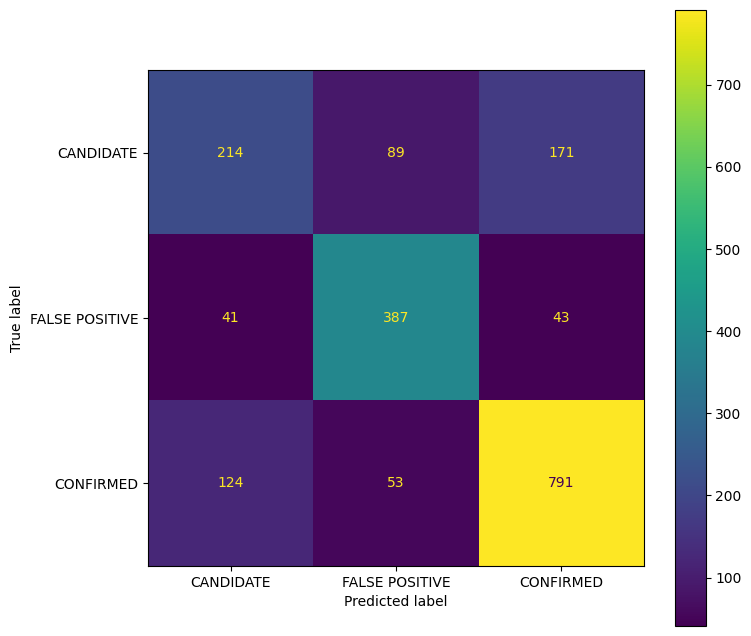

In [8]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, Y_test, display_labels = [str(x) for x in Y_test['koi_disposition'].unique()], ax = plt.subplot());

Coeficientes de los atributos por clase:


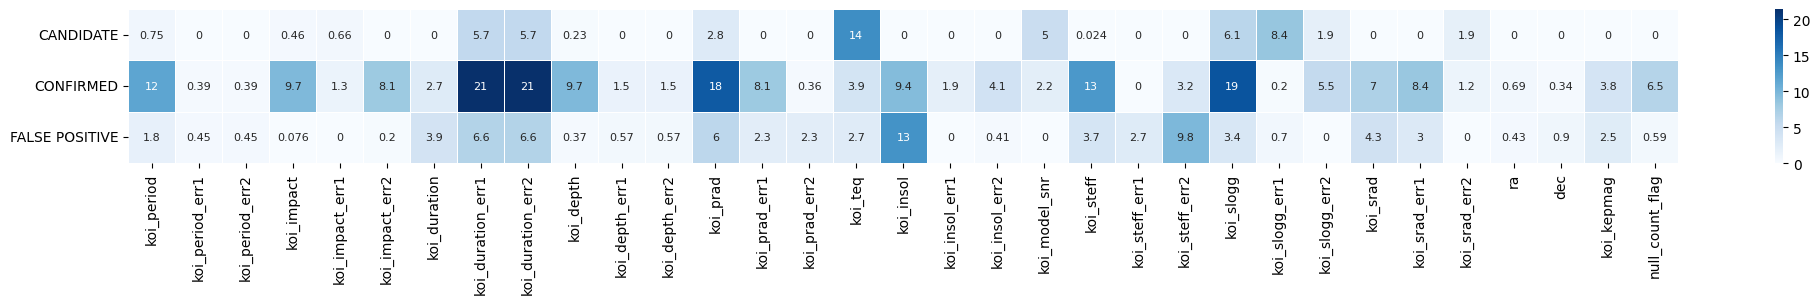


Coeficientes de los atributos (avg):


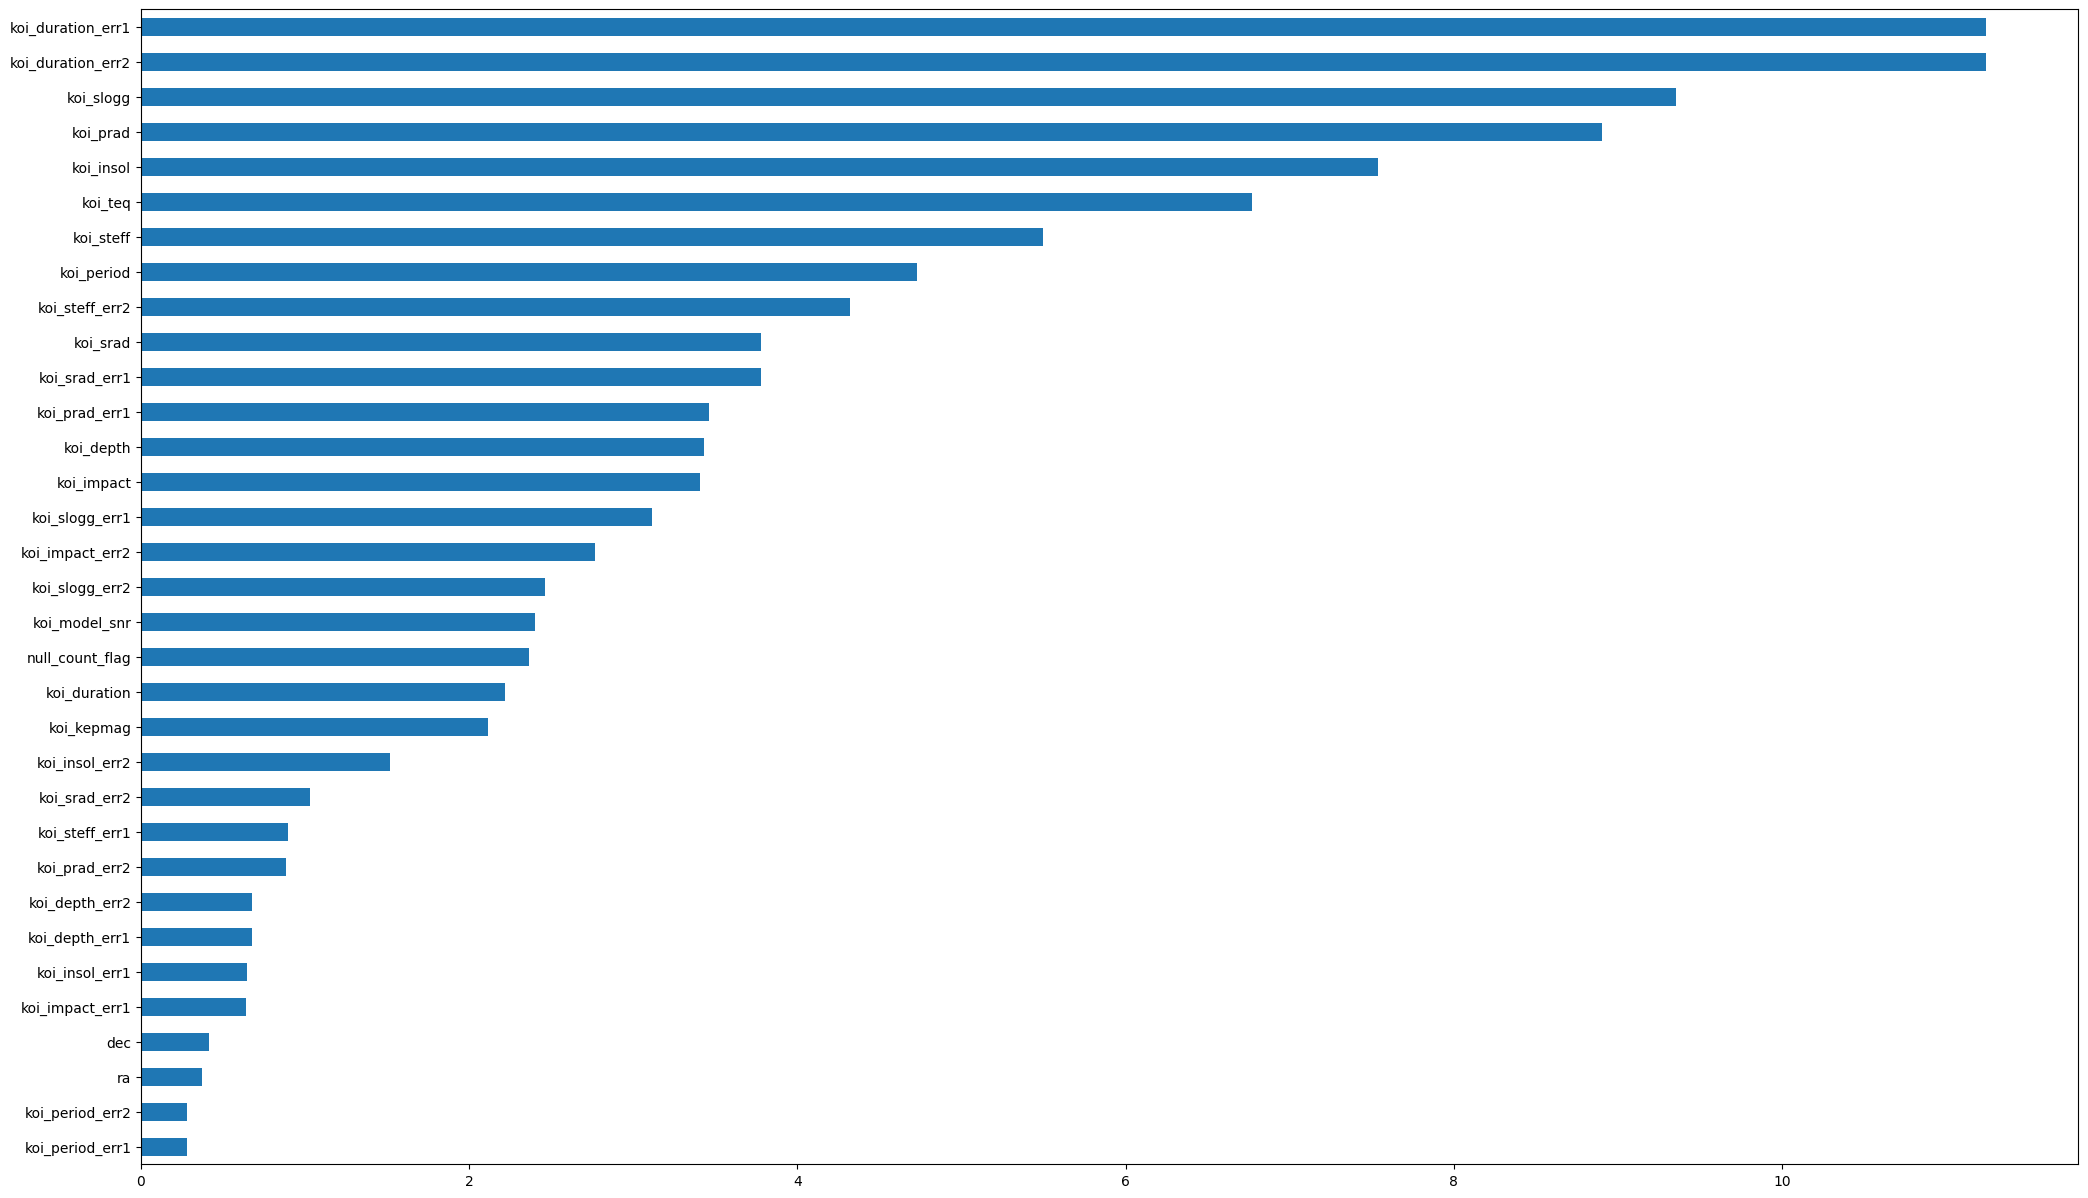

In [9]:
print('Coeficientes de los atributos por clase:')
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns
coefs.index = [str(x) for x in lr_gs.best_estimator_.classes_]
plt.figure(figsize = (25, 2));
sns.heatmap(coefs.abs(), annot = True, linewidths = .5, cbar = True, xticklabels = True, cmap = 'Blues', annot_kws = {'size': 8});
plt.show()

print('\n' + "Coeficientes de los atributos (avg):")
coefs = pd.DataFrame(lr_gs.best_estimator_.coef_)
coefs.columns = X_train.columns
importance = coefs.abs().mean(axis = 0)
importance.sort_values().plot.barh(figsize = (25, 15));

## 2) SVM Lineal

In [10]:
param = {'C':[1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]}
lsvc = SVC(kernel = 'linear', probability = True, max_iter = 20000, random_state = 42)
glsvc = GridSearchCV(lsvc, param, cv = cv, n_jobs = -1, refit = True);
glsvc.fit(X_train, Y_train);
show_html(pd.DataFrame(glsvc.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').to_html());

,params,mean_test_score,rank_test_score
11,{'C': 10.0},0.741076,1
12,{'C': 100.0},0.735195,2
10,{'C': 1},0.733889,3
9,{'C': 0.1},0.708011,4
8,{'C': 0.01},0.635602,5
0,{'C': 1e-10},0.506078,6
2,{'C': 1e-08},0.506078,6
1,{'C': 1e-09},0.506078,6
7,{'C': 0.001},0.506078,6
6,{'C': 0.0001},0.506078,6


In [11]:
print(classification_report(Y_test, glsvc.predict(X_test), target_names = [str(x) for x in Y_test['koi_disposition'].unique()]))
results_df = save_results(glsvc, X_test, Y_test, 'SVM Lineal', results_df)

                precision    recall  f1-score   support

     CANDIDATE       0.57      0.49      0.52       474
FALSE POSITIVE       0.73      0.82      0.77       471
     CONFIRMED       0.80      0.81      0.81       968

      accuracy                           0.73      1913
     macro avg       0.70      0.71      0.70      1913
  weighted avg       0.73      0.73      0.73      1913



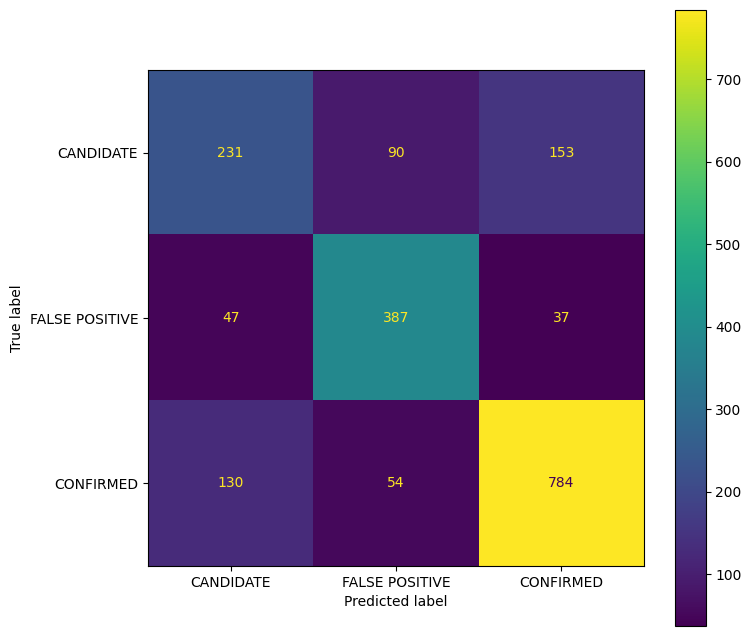

In [12]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(glsvc, X_test, Y_test, display_labels = [str(x) for x in Y_test['koi_disposition'].unique()], ax = plt.subplot());

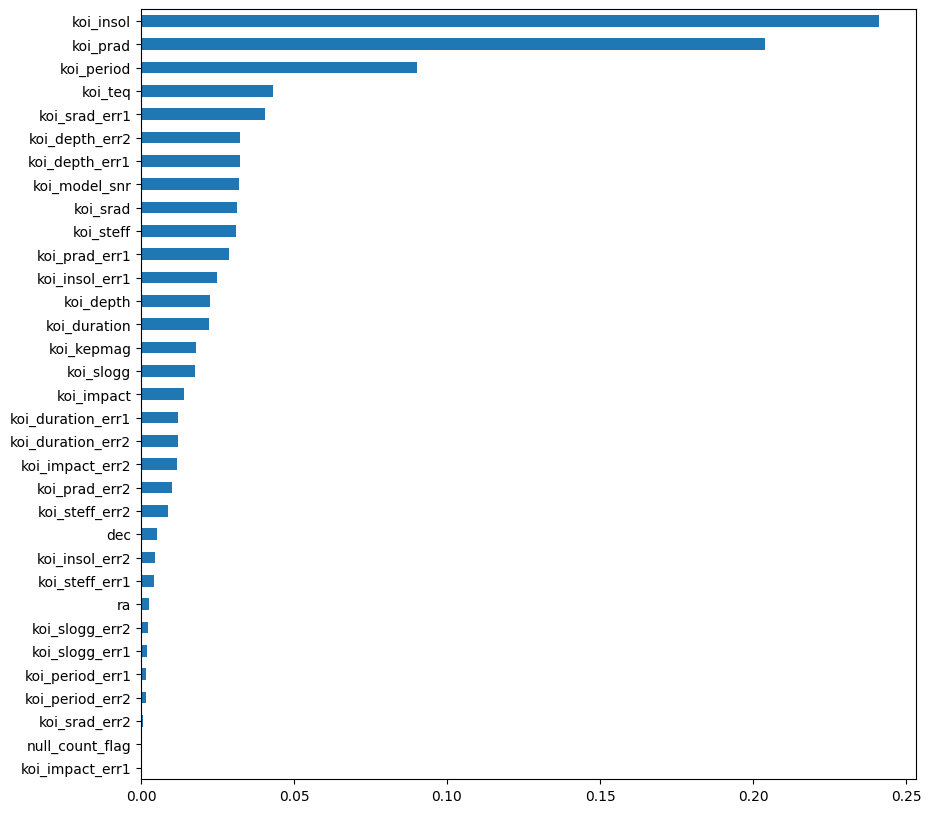

In [13]:
pi = permutation_importance(glsvc, X_test, Y_test, n_jobs = -1, random_state = 42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = X_train.columns)
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

## 3) QDA

In [14]:
param = {'reg_param': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
qda = QuadraticDiscriminantAnalysis()
gqda = GridSearchCV(qda, param, cv = cv, n_jobs = -1, refit = True);
gqda.fit(X_train, Y_train);
show_html(pd.DataFrame(gqda.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').to_html());

,params,mean_test_score,rank_test_score
2,{'reg_param': 0.2},0.635734,1
3,{'reg_param': 0.3},0.617957,2
1,{'reg_param': 0.1},0.600574,3
4,{'reg_param': 0.4},0.584499,4
5,{'reg_param': 0.5},0.528689,5
7,{'reg_param': 0.7},0.506078,6
9,{'reg_param': 0.9},0.506078,6
8,{'reg_param': 0.8},0.506078,6
10,{'reg_param': 1},0.506078,6
6,{'reg_param': 0.6},0.505947,10


In [15]:
print(classification_report(Y_test, gqda.predict(X_test), target_names = [str(x) for x in Y_test['koi_disposition'].unique()]))
results_df = save_results(gqda, X_test, Y_test, 'QDA', results_df)

                precision    recall  f1-score   support

     CANDIDATE       0.49      0.21      0.30       474
FALSE POSITIVE       0.49      0.88      0.63       471
     CONFIRMED       0.76      0.67      0.71       968

      accuracy                           0.61      1913
     macro avg       0.58      0.59      0.55      1913
  weighted avg       0.62      0.61      0.59      1913



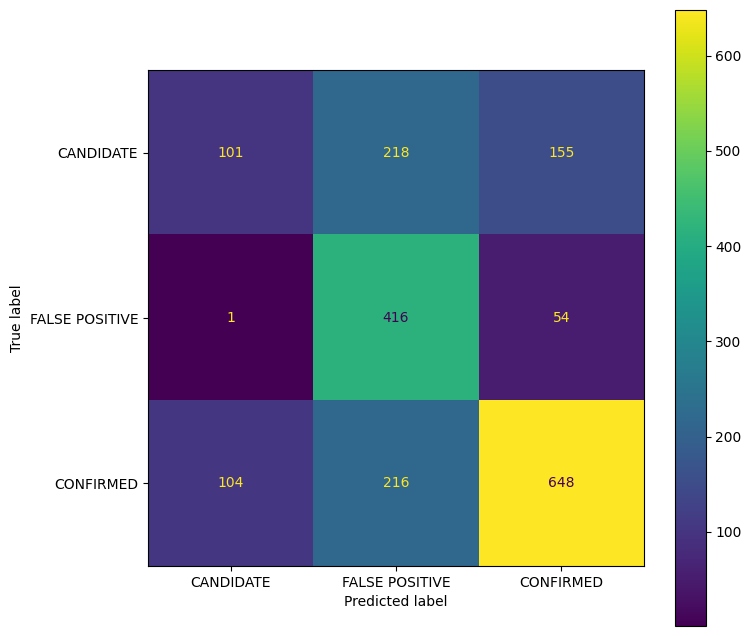

In [16]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(gqda, X_test, Y_test, display_labels = [str(x) for x in Y_test['koi_disposition'].unique()], ax = plt.subplot());

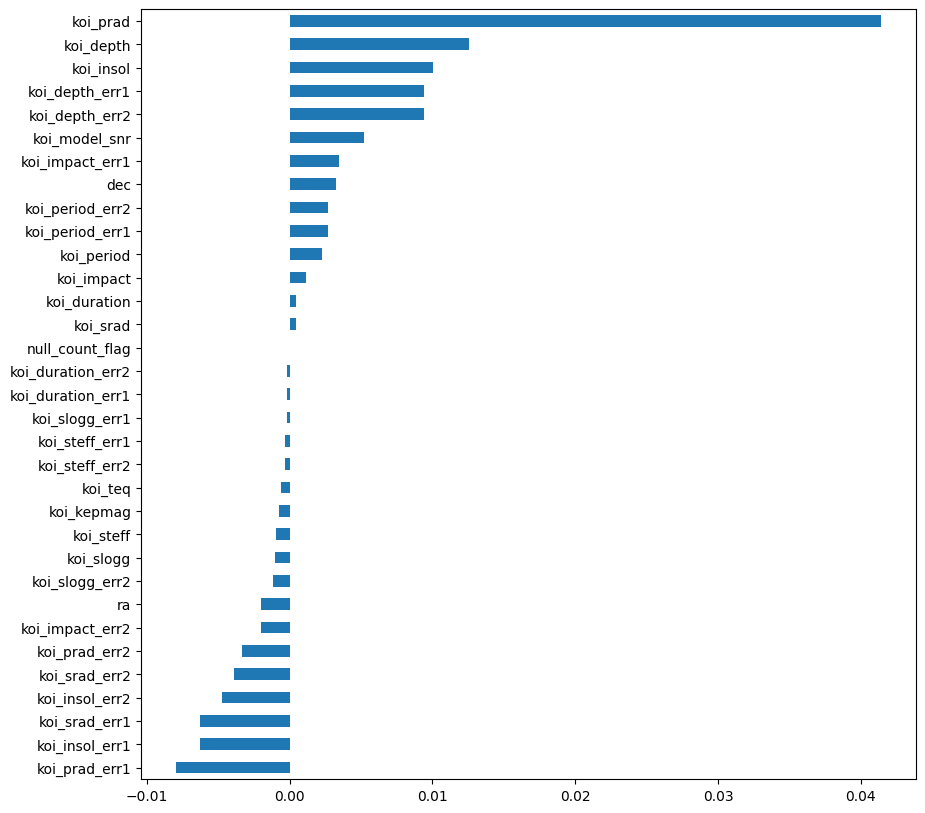

In [17]:
pi = permutation_importance(gqda, X_test, Y_test, n_jobs = -1, random_state = 42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = X_train.columns)
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

## MODELOS NO LINEALES

## 1) Random Forest

In [18]:
param = {'n_estimators':[5, 10, 20, 30, 40, 50, 75, 100, 150, 200], 'criterion':['gini', 'entropy'], 'max_depth':[None, 3, 5, 7, 9, 11, 13, 15, 20],'min_samples_leaf':[1, 2, 3, 5, 10]}
rf =  RandomForestClassifier(oob_score = True, random_state = 42)
grf =  GridSearchCV(rf, param, cv = cv, n_jobs = -1, refit = True);
grf.fit(X_train, Y_train);
show_html(pd.DataFrame(grf.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').head().to_html());

,params,mean_test_score,rank_test_score
359,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 200}",0.781987,1
468,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 150}",0.780027,2
358,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 150}",0.779765,3
357,"{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 100}",0.779634,4
467,"{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}",0.779504,5


In [19]:
print(classification_report(Y_test, grf.predict(X_test), target_names = [str(x) for x in Y_test['koi_disposition'].unique()]))
results_df = save_results(grf, X_test, Y_test, 'Random Forest', results_df)

                precision    recall  f1-score   support

     CANDIDATE       0.62      0.49      0.55       474
FALSE POSITIVE       0.79      0.81      0.80       471
     CONFIRMED       0.81      0.88      0.84       968

      accuracy                           0.77      1913
     macro avg       0.74      0.73      0.73      1913
  weighted avg       0.76      0.77      0.76      1913



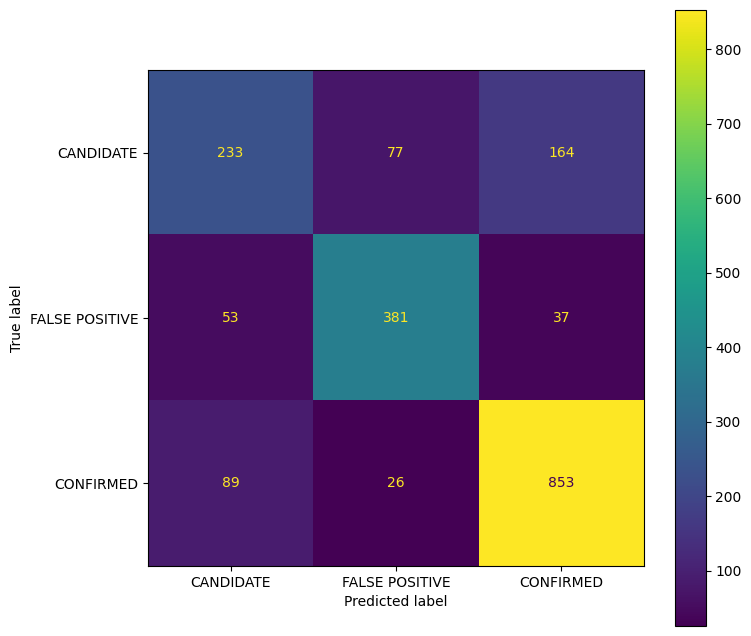

In [20]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(grf, X_test, Y_test, display_labels = [str(x) for x in Y_test['koi_disposition'].unique()], ax = plt.subplot());

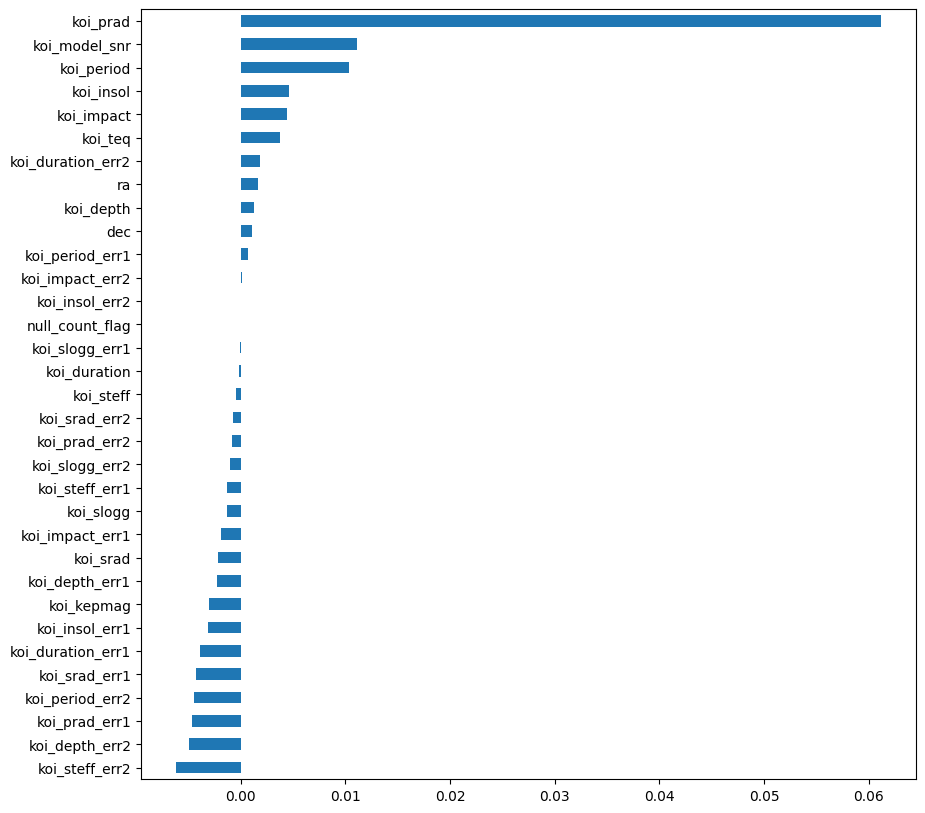

In [21]:
pi = permutation_importance(grf, X_test, Y_test, n_jobs = -1, random_state = 42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = X_train.columns)
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

## 2) Gradient Boosting

In [ ]:
param = {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [3, 5, 7],
        "min_samples_leaf": [2, 5],
        "subsample": [0.8, 1.0],
        "max_features": ["sqrt", "log2", None]}
gb = GradientBoostingClassifier(random_state = 42)
# usamos RandomizedSearchCV en vez de GridSearchCV para optimizar: reduce (10-20x) el tiempo con pérdida mínima de calidad
ggb =  BayesSearchCV(gb, param, n_iter = 50, cv = cv, n_jobs = -1, random_state = 42);
ggb.fit(X_train, Y_train);
show_html(pd.DataFrame(ggb.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').head().to_html());

,params,mean_test_score,rank_test_score
18,"{'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100, 'subsample': 1.0}",0.786302,1
13,"{'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 1.0}",0.786040,2
24,"{'learning_rate': 0.05, 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 95, 'subsample': 0.8386120913714717}",0.784601,3
14,"{'learning_rate': 0.1, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 1.0}",0.784471,4
40,"{'learning_rate': 0.05, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 100, 'subsample': 1.0}",0.784079,5


In [25]:
print(classification_report(Y_test, ggb.predict(X_test), target_names = [str(x) for x in Y_test['koi_disposition'].unique()]))
results_df = save_results(ggb, X_test, Y_test, 'Gradient Boosting', results_df)

                precision    recall  f1-score   support

     CANDIDATE       0.63      0.55      0.59       474
FALSE POSITIVE       0.81      0.81      0.81       471
     CONFIRMED       0.83      0.88      0.85       968

      accuracy                           0.78      1913
     macro avg       0.75      0.75      0.75      1913
  weighted avg       0.77      0.78      0.77      1913



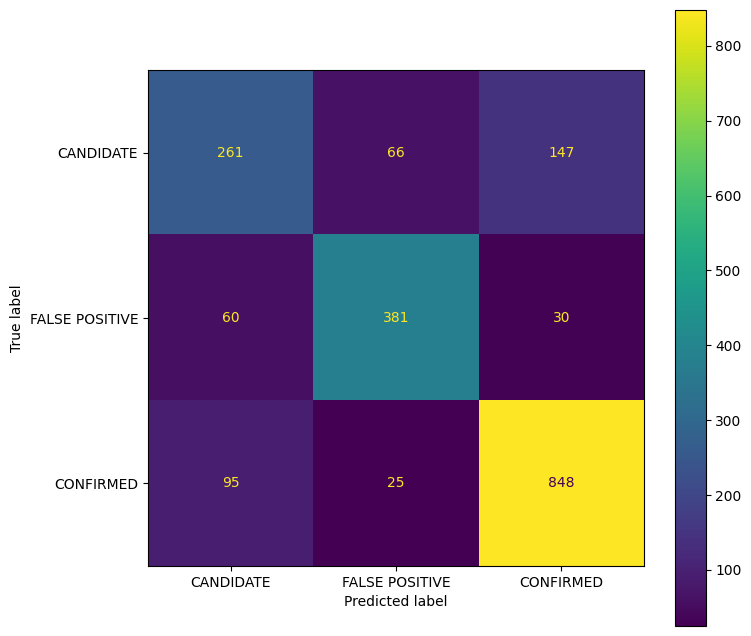

In [26]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(ggb, X_test, Y_test, display_labels = [str(x) for x in Y_test['koi_disposition'].unique()], ax = plt.subplot());

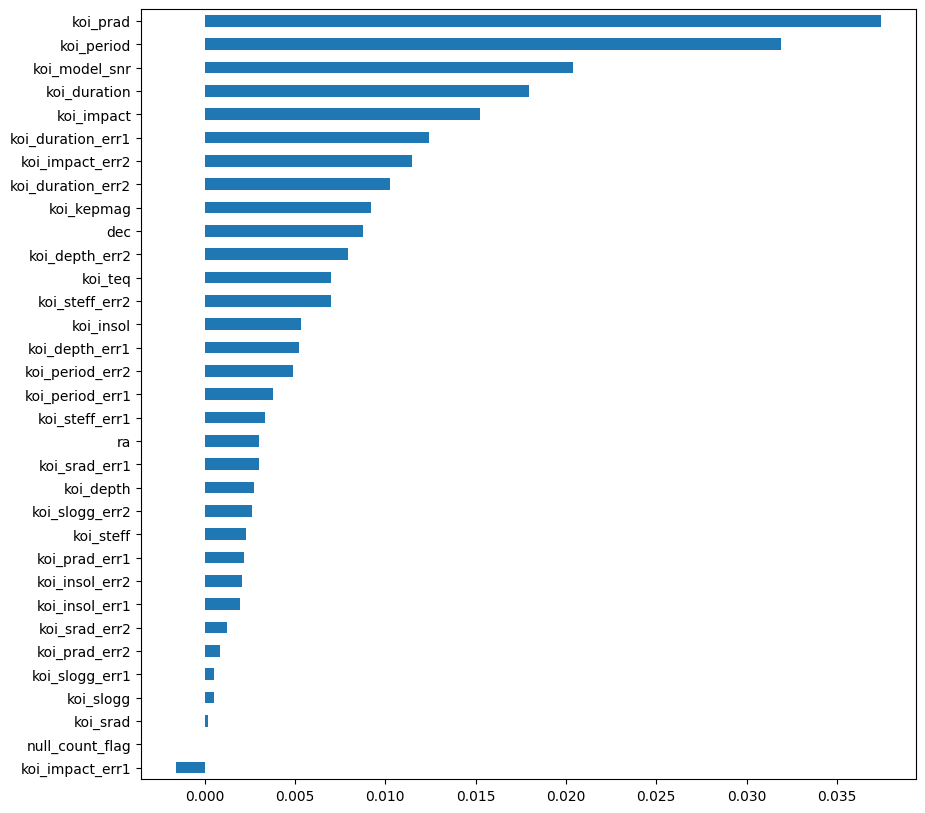

In [27]:
pi = permutation_importance(ggb, X_test, Y_test, n_jobs = -1, random_state = 42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = X_train.columns)
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

## 3) MLP

In [37]:
hidden_layer_sizes = [(32,), (64,), (128,), (256,), (512,),
                      (64, 32), (128, 64), (256, 128), (512, 256),
                      (128, 64, 32), (256, 128, 64), (512, 256, 128)]
param = {
    'hidden_layer_sizes': hidden_layer_sizes,
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'early_stopping': [True]
}
mlp =  MLPClassifier(random_state = 42, max_iter = 2000);
gmlp =  GridSearchCV(mlp, param, cv = cv, n_jobs = -1, refit = True);
gmlp.fit(X_train, Y_train['koi_disposition'].map({'CONFIRMED':0, 'CANDIDATE':1, 'FALSE POSITIVE':2}));
show_html(pd.DataFrame(gmlp.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by = 'rank_test_score').head().to_html());

,params,mean_test_score,rank_test_score
17,"{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (512, 256), 'learning_rate': 'adaptive', 'solver': 'adam'}",0.772839,1
16,"{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (512, 256), 'learning_rate': 'constant', 'solver': 'adam'}",0.772839,1
43,"{'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'adaptive', 'solver': 'adam'}",0.772053,3
42,"{'activation': 'relu', 'alpha': 0.001, 'early_stopping': True, 'hidden_layer_sizes': (128, 64, 32), 'learning_rate': 'constant', 'solver': 'adam'}",0.772053,3
23,"{'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (512, 256, 128), 'learning_rate': 'adaptive', 'solver': 'adam'}",0.771793,5


In [ ]:
print(classification_report(Y_test, gmlp.predict(X_test), target_names = [str(x) for x in Y_test['koi_disposition'].unique()]))
results_df = save_results(gmlp, X_test, Y_test, 'MLP', results_df)

In [ ]:
plt.figure(figsize = (8, 8));
ConfusionMatrixDisplay.from_estimator(gmlp, X_test, Y_test, display_labels = [str(x) for x in Y_test['koi_disposition'].unique()], ax = plt.subplot());

In [ ]:
pi = permutation_importance(gmlp, X_test, Y_test, n_jobs = -1, random_state = 42)
var_imp = pd.DataFrame({'importance': pi.importances_mean}, index = X_train.columns)
var_imp.sort_values(by = 'importance').plot.barh(figsize = (10, 10), legend = False);

## COMPARACIÓN DE MODELOS

In [ ]:
results_df = results_df.sort_values('train XV acc', ascending = False)
print("Resultados de Validación Cruzada:")
print(results_df['train XV acc'].to_string())

# Visualización
plt.figure(figsize = (12, 6))
colors = ['skyblue']*3 + ['lightcoral']*3
bars = plt.bar(range(len(results_df)), results_df['train XV acc'], color = colors)
plt.xticks(range(len(results_df)), results_df.index, rotation = 45, ha = 'right')
plt.ylabel('Accuracy (CV)')
plt.title('Comparación de Modelos - Validación Cruzada')
plt.axhline(y = results_df['train XV acc'].mean(), color = 'red', linestyle = '--', 
            label = f'Media: {results_df["train XV acc"].mean():.4f}')
plt.legend()
plt.tight_layout()
plt.savefig('model_comparison_cv.png', dpi = 300, bbox_inches = 'tight')
plt.show()

## SELECCIÓN MEJOR MODELO

In [ ]:
best_model_name = results_df.index[0]
print(f"Modelo seleccionado: {best_model_name}")
print(f"CV Score: {results_df.loc[best_model_name, 'train XV acc']:.4f}")